In [1]:
% lsmagic

Available line magics:
%alias  %alias_magic  %autocall  %automagic  %autosave  %bookmark  %cd  %clear  %cls  %colors  %config  %connect_info  %copy  %ddir  %debug  %dhist  %dirs  %doctest_mode  %echo  %ed  %edit  %env  %gui  %hist  %history  %killbgscripts  %ldir  %less  %load  %load_ext  %loadpy  %logoff  %logon  %logstart  %logstate  %logstop  %ls  %lsmagic  %macro  %magic  %matplotlib  %mkdir  %more  %notebook  %page  %pastebin  %pdb  %pdef  %pdoc  %pfile  %pinfo  %pinfo2  %popd  %pprint  %precision  %profile  %prun  %psearch  %psource  %pushd  %pwd  %pycat  %pylab  %qtconsole  %quickref  %recall  %rehashx  %reload_ext  %ren  %rep  %rerun  %reset  %reset_selective  %rmdir  %run  %save  %sc  %set_env  %store  %sx  %system  %tb  %time  %timeit  %unalias  %unload_ext  %who  %who_ls  %whos  %xdel  %xmode

Available cell magics:
%%!  %%HTML  %%SVG  %%bash  %%capture  %%cmd  %%debug  %%file  %%html  %%javascript  %%js  %%latex  %%markdown  %%perl  %%prun  %%pypy  %%python  %%python2  %%py

In [2]:
%pwd

'C:\\Users\\Maks\\kaggle-competitions\\Humpback-Whale-Identification\\code\\notebooks'

In [6]:
%%bash

cd ..
ls

files
notebooks
scripts


In [7]:
%pwd

'C:\\Users\\Maks\\kaggle-competitions\\Humpback-Whale-Identification\\code\\notebooks'

In [9]:
import zipfile

input_data_folder = 'C:/Users/Maks/kaggle-competitions/Humpback-Whale-Identification/data/input/'
train_data_zip = input_data_folder + 'train.zip'
train_data_csv = input_data_folder + 'train.csv'
test_data_zip = input_data_folder + 'test.zip'

with zipfile.ZipFile(train_data_zip, 'r') as train_data:
    train_data.extractall()

In [10]:
train_dir = input_data_folder + 'train'
test_dir = input_data_folder + 'test'

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [14]:
train_csv = pd.read_csv(input_data_folder + 'train.csv')

In [15]:
train_csv.head()

,Image,Id
0,0000e88ab.jpg,w_f48451c
1,0001f9222.jpg,w_c3d896a
2,00029d126.jpg,w_20df2c5
3,00050a15a.jpg,new_whale
4,0005c1ef8.jpg,new_whale


In [25]:
print(len(train_csv['Id']))
print(len(train_csv['Id'].unique()))

25361
5005


In [32]:
import cv2
import sys
import os

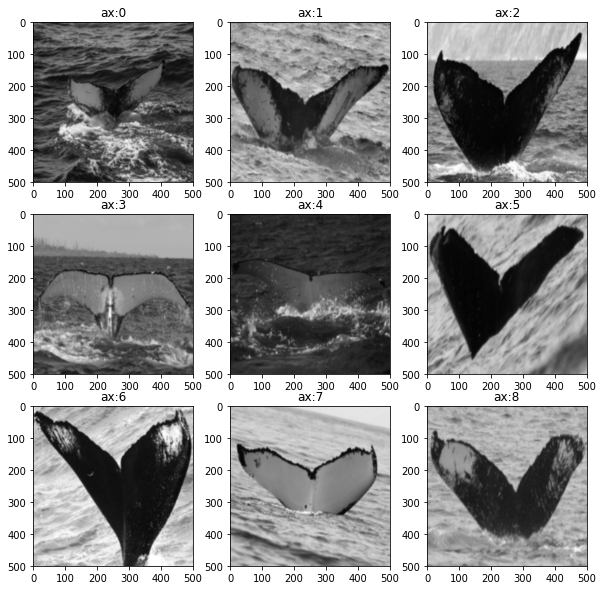

In [83]:
fig = plt.figure(figsize=(10, 10))

ax = []



i = 0
for image in os.listdir(train_dir):
    if i < 9:
        img = cv2.imread(train_dir + '/' + image, 0) # read image in grayscale
        resized_img = cv2.resize(img, (500, 500))
        ax.append(fig.add_subplot(3, 3, i + 1))
        ax[-1].set_title('ax:' + str(i))
        plt.imshow(resized_img, cmap = 'gray', interpolation = 'bicubic')
    i += 1

In [58]:
NUM_TRAIN_IMAGES = len([image for image in os.listdir(train_dir) 
                        if os.path.isfile(os.path.join(train_dir, image))])

In [59]:
NUM_TRAIN_IMAGES

25361

In [74]:
BATCH_SIZE = 128

In [75]:
IMAGE_SIZE = (500 * 500)

In [90]:
from scipy import misc
import numpy as np
from PIL import Image
import imageio

In [69]:
train_dir

'C:/Users/Maks/kaggle-competitions/Humpback-Whale-Identification/data/input/train'

In [92]:
train_data = np.zeros((BATCH_SIZE, IMAGE_SIZE))

for i, image in enumerate(os.listdir(train_dir)):
    
    if(i < BATCH_SIZE):
    
        I = np.asarray(Image.open(train_dir + '/' + image).convert('L'))
        I = np.array(Image.fromarray(I).resize(size=(500, 500)))
        I = np.float16(np.reshape(I, [1, IMAGE_SIZE])) / 255
        train_data[i, :] = I

        if i % 100 == 0:
            print(str(i * 100 / BATCH_SIZE) + '% done', end='\n')

0.0% done
78.125% done


In [95]:
train_data

array([[0.2902832 , 0.27441406, 0.22351074, ..., 0.14123535, 0.13330078,
        0.26660156],
       [0.62353516, 0.71386719, 0.69824219, ..., 0.65869141, 0.63134766,
        0.72558594],
       [0.87841797, 0.87451172, 0.87060547, ..., 0.52148438, 0.54492188,
        0.54492188],
       ...,
       [0.92138672, 0.91748047, 0.90576172, ..., 0.99609375, 0.99609375,
        0.99609375],
       [0.78417969, 0.77636719, 0.78417969, ..., 0.31762695, 0.31762695,
        0.31762695],
       [0.58837891, 0.60009766, 0.60791016, ..., 0.61181641, 0.61181641,
        0.60791016]])

In [97]:
train_data.shape

(128, 250000)

In [111]:
from keras.layers import Input, Conv2D, Lambda, Concatenate, Dense, Flatten,MaxPooling2D
from keras.models import Model, Sequential
from keras.regularizers import l2
from keras import backend as K
from keras.optimizers import SGD,Adam
from keras.losses import binary_crossentropy
import numpy.random as rng
import numpy as np
import os
import dill as pickle
import matplotlib.pyplot as plt
from sklearn.utils import shuffle

def W_init(shape,name=None):
    """Initialize weights as in paper"""
    values = rng.normal(loc=0,scale=1e-2,size=shape)
    return K.variable(values,name=name)
#//TODO: figure out how to initialize layer biases in keras.
def b_init(shape,name=None):
    """Initialize bias as in paper"""
    values=rng.normal(loc=0.5,scale=1e-2,size=shape)
    return K.variable(values,name=name)

input_shape = (105, 105, 1)
left_input = Input(input_shape)
right_input = Input(input_shape)
#build convnet to use in each siamese 'leg'
convnet = Sequential()
convnet.add(Conv2D(64,(10,10),activation='relu',input_shape=input_shape,
                   kernel_initializer=W_init,kernel_regularizer=l2(2e-4)))
convnet.add(MaxPooling2D())
convnet.add(Conv2D(128,(7,7),activation='relu',
                   kernel_regularizer=l2(2e-4),kernel_initializer=W_init,bias_initializer=b_init))
convnet.add(MaxPooling2D())
convnet.add(Conv2D(128,(4,4),activation='relu',kernel_initializer=W_init,kernel_regularizer=l2(2e-4),bias_initializer=b_init))
convnet.add(MaxPooling2D())
convnet.add(Conv2D(256,(4,4),activation='relu',kernel_initializer=W_init,kernel_regularizer=l2(2e-4),bias_initializer=b_init))
convnet.add(Flatten())
convnet.add(Dense(4096,activation="sigmoid",kernel_regularizer=l2(1e-3),kernel_initializer=W_init,bias_initializer=b_init))
#encode each of the two inputs into a vector with the convnet
encoded_l = convnet(left_input)
encoded_r = convnet(right_input)
#merge two encoded inputs with the l1 distance between them
l1_distance = Lambda(lambda x: K.abs(x[0]-x[1]))([encoded_l, encoded_r])
prediction = Dense(1,activation='sigmoid',bias_initializer=b_init)(l1_distance)
siamese_net = Model(input=[left_input,right_input],output=prediction)
#optimizer = SGD(0.0004,momentum=0.6,nesterov=True,decay=0.0003)

optimizer = Adam(0.00006)
#//TODO: get layerwise learning rates and momentum annealing scheme described in paperworking
siamese_net.compile(loss="binary_crossentropy",optimizer=optimizer, 
                   metrics = ['binary_crossentropy', 'acc'])

siamese_net.count_params()
siamese_net.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_23 (InputLayer)           (None, 105, 105, 1)  0                                            
__________________________________________________________________________________________________
input_24 (InputLayer)           (None, 105, 105, 1)  0                                            
__________________________________________________________________________________________________
sequential_12 (Sequential)      (None, 4096)         38947648    input_23[0][0]                   
                                                                 input_24[0][0]                   
__________________________________________________________________________________________________
lambda_4 (Lambda)               (None, 4096)         0           sequential_12[1][0]              
          

C:\Users\Maks\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:46: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=[<tf.Tenso..., outputs=Tensor("de...)`


In [ ]:
class Siamese_Loader:
    """For loading batches and testing tasks to a siamese net"""
    def __init__(self, x_train, x_val):
        self.x_val = x_val
        self.x_train = x_train
    
    def get_batch(self, n):
        """Create batch of n pair, half same, half different class"""
        categories = rng(self.n_classes, size=(n, ), replace=False)